Run the cell below to import the required packages:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV

import warnings
warnings.filterwarnings("ignore")

Let's read in the Boston dataset again and make a dataframe out of it:

In [19]:
boston = load_boston()
X = boston.data
y = boston.target

Recall that we previously compared train/validation/test splits to cross-validation methods:

Advantages of a **train/validation/test split:**

- Runs K times faster than K-fold cross-validation
- Simpler to examine the detailed results of the testing process

Advantages of **cross validation:**

- More accurate estimate of out-of-sample accuracy
- More "efficient" use of data (every observation is used for both training and testing)

Recommendations for **cross validation:**

- K can be any number, but K=4 or 5 is common

- Each response class should be represented with equal proportions in each of the K folds

- Scikit-learn's cross_val_score function does this by default




### Using Validation Sets to Tune Hyperparameters: Test/Train/Split
In the Ridge examples below, we would like to tune alpha, so we will create a validation set.

To create a validation set, we'll need to use test/train/split twice, once to separate the test set and then again to separate the validation set. We'll separate the data into 60% training, 20% validation, and 20% testing:

In [20]:
# intermediate/test split (gives us test set)
X_intermediate, X_test, y_intermediate, y_test = train_test_split(X, 
                                                                  y, 
                                                                  shuffle=True,
                                                                  test_size=0.2, 
                                                                  random_state=15)

# train/validation split (gives us train and validation sets)
X_train, X_validation, y_train, y_validation = train_test_split(X_intermediate,
                                                                y_intermediate,
                                                                shuffle=False,
                                                                test_size=0.25,
                                                                random_state=2018)
# delete intermediate variables
del X_intermediate, y_intermediate

# print proportions
print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(y),2),
                                                       round(len(y_validation)/len(y),2),
                                                       round(len(y_test)/len(y),2)))

train: 0.6% | validation: 0.2% | test 0.2%


Recall that regularization is a form of constrained optimization that imposes limits on determining model parameters. It effectively allows us to add bias to a model that’s overfitting (overfitting occurs when your model is so specific to your training dataset that it does worse in predicting your test data). We can control the amount of bias with a hyperparameter called lambda (called alpha in Python since lambda is a reserved word) that defines regularization strength. Let's see below how we can test different values of alpha against our validation set in order to get the best hyperparameter:

In [22]:
alphas = [0.001, 0.01, 0.1, 1, 10]
print('Mean Squared Error')
print('-'*76)

for alpha in alphas:
    # instantiate and fit model
    model = Ridge(alpha=alpha, fit_intercept=True, random_state=99)
    model.fit(X_train, y_train)
    
    # calculate errors
    new_train_error = mean_squared_error(y_train, model.predict(X_train))
    new_validation_error = mean_squared_error(y_validation, model.predict(X_validation))
    new_test_error = mean_squared_error(y_test, model.predict(X_test))
    

    new_validation_r2 = model.score(X_validation, y_validation)
    new_test_r2 = model.score(X_test, y_test)
    
    # print errors as report
    print('alpha: {:7} | train error: {:5} | val error: {:6} | test error: {:6} | val R^2: {} | test R^2: {}'.
          format(alpha,
                 round(new_train_error,3),
                 round(new_validation_error,3),
                 round(new_test_error,3),
                 round(new_validation_r2,3),
                 round(new_test_r2,3)))

Mean Squared Error
----------------------------------------------------------------------------
alpha:   0.001 | train error: 22.924 | val error: 19.804 | test error: 23.958 | val R^2: 0.719 | test R^2: 0.69
alpha:    0.01 | train error: 22.924 | val error: 19.801 | test error: 23.943 | val R^2: 0.72 | test R^2: 0.69
alpha:     0.1 | train error: 22.938 | val error: 19.791 | test error:  23.82 | val R^2: 0.72 | test R^2: 0.692
alpha:       1 | train error: 23.315 | val error: 20.158 | test error: 23.533 | val R^2: 0.714 | test R^2: 0.696
alpha:      10 | train error: 24.199 | val error: 20.981 | test error: 23.369 | val R^2: 0.703 | test R^2: 0.698


There are a few key takeaways here. First, notice the U-shaped behavior exhibited by the validation error above. It starts around 19.8, goes down for two steps and then back up. Also notice that validation error and test error tend to move together, but by no means is the relationship perfect. We see both errors decrease as alpha increases initially but then test error keeps going down while validation error rises again. 

The U shape is typical. We prefer to be somewhere in the sweet spot between not overfitting (having too little error in the training data) and not underfitting (having too much error in the training data).


<img src="images/train2.png" width="400">

In our case, we'll decide to use alpha=0.1 to now train our entire training dataset since this gave us the smallest validation error:

In [23]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    shuffle=True,
                                                    test_size=0.2, 
                                                    random_state=15)

# instantiate model
model = Ridge(alpha=0.1, fit_intercept=True, random_state=99)

#fit model
model.fit(X_train, y_train)

#evaluate model
new_train_error = mean_squared_error(y_train, model.predict(X_train))
new_test_error = mean_squared_error(y_test, model.predict(X_test))
print('MSE train error:', new_train_error, 'R2 train: ', model.score(X_train, y_train))
print('MSE test error:', new_test_error, 'R2 test: ', model.score(X_test, y_test))

MSE train error: 21.87892746431845 R2 train:  0.7454491108712407
MSE test error: 23.679851355216798 R2 test:  0.6937869418612654


Thus, we can conclude that 69.4% of the variation in home price in our test set can be attributed to variation in our explanatory variables.

### Using Validation Sets to Tune Hyperparameters: Cross Validation

Cross validation assigns a certain percentage of the dataset to test data, and then does this multiple times. Using `cross_val_score` is convenient. Be careful, though:

### Shuffle!
If we are splitting the data into training/testing samples, we definitely need the data shuffled first! Some methods like train_test_split above have shuffling options built into their methods, but others like cross_val_score and RidgeCV do not. Therefore, we'll first shuffle our data below. To do so, there is a built in pandas command that is helpful. We'll put our X and y data into a dataframe and then after shuffling, we can then update X and y to be the input and output information:

In [24]:
boston = load_boston()
df = pd.DataFrame(boston.data)
X = boston.data
df['y'] = boston.target

df = df.sample(frac=1).reset_index(drop=True)

y = df['y']
X = df.drop(columns = 'y')

Now, we can use our cross_val_score method:

In [25]:
alphas = [0.001, 0.01, 0.1, 1, 10]
print('Mean Squared Error')
print('-'*76)
for alpha in alphas:
    # instantiate and fit model
    model = Ridge(alpha=alpha, fit_intercept=True, random_state=99)
    
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

    # print errors as report
    print('alpha: {:6} | MSE scores: {} | Average MSE: {:.6}'.
          format(alpha,
                 -scores,
                 np.mean(-scores)))

Mean Squared Error
----------------------------------------------------------------------------
alpha:  0.001 | MSE scores: [26.57233662 21.91074642 23.42316708 24.67682047 20.86128944] | Average MSE: 23.4889
alpha:   0.01 | MSE scores: [26.57853878 21.91133486 23.42120193 24.67010296 20.8555953 ] | Average MSE: 23.4874
alpha:    0.1 | MSE scores: [26.64087191 21.91985453 23.40938461 24.61532013 20.80892817] | Average MSE: 23.4789
alpha:      1 | MSE scores: [27.15142583 22.07058026 23.52961087 24.55172352 20.74643357] | Average MSE: 23.61
alpha:     10 | MSE scores: [28.23480844 22.4220372  23.64872423 25.16467827 21.16148753] | Average MSE: 24.1263


We notice that alpha = 0.1 gives us the lowest mean squared error, so we choose to use that one:

In [26]:
model = Ridge(alpha=0.1, fit_intercept=True, random_state=99)

scores = cross_val_score(model, X, y, cv=5, scoring='r2')

print('R2 test error', np.mean(scores))

R2 test error 0.7160195224364472


### What is alpha doing here?

We should take a step back and make sure we understand what tuning alpha did in the above examples. We were not using higher order polynomials and so alpha definitely was not penalizing high degree polynomials. Instead, it was penalizing the complexity of all of the linear features in our model, since the Boston dataset has 13 predictor variables:

In [32]:
X.shape

(506, 13)

Notice the coefficients for the model using alpha = 0.1:

In [30]:
model = Ridge(alpha=0.1, fit_intercept=True, random_state=99)
model.fit(X,y)
model.coef_

array([-1.07473720e-01,  4.65716366e-02,  1.59989982e-02,  2.67001859e+00,
       -1.66846452e+01,  3.81823322e+00, -2.69060598e-04, -1.45962557e+00,
        3.03515266e-01, -1.24205910e-02, -9.40758541e-01,  9.36807461e-03,
       -5.25966203e-01])

These are much smaller than the coefficients using alpha = 10:

In [33]:
model = Ridge(alpha=10, fit_intercept=True, random_state=99)
model.fit(X,y)
model.coef_

array([-0.10143535,  0.0495791 , -0.0429624 ,  1.95202082, -2.37161896,
        3.70227207, -0.01070735, -1.24880821,  0.2795956 , -0.01399313,
       -0.79794498,  0.01003684, -0.55936642])

### Sine example

Now, let's indeed return to an example in which we used higher degree polynomials. 
Let's return to our $f(x)=\sin(2 \pi x)$ example from the last notebook in which we decided on a degree of 3:

alpha:  1e-08     R^2: 0.7975694106142842
alpha:  0.1     R^2: 0.41073128170897105
alpha:  1     R^2: 0.37112276205445915
alpha:  10     R^2: 0.28458540377371144


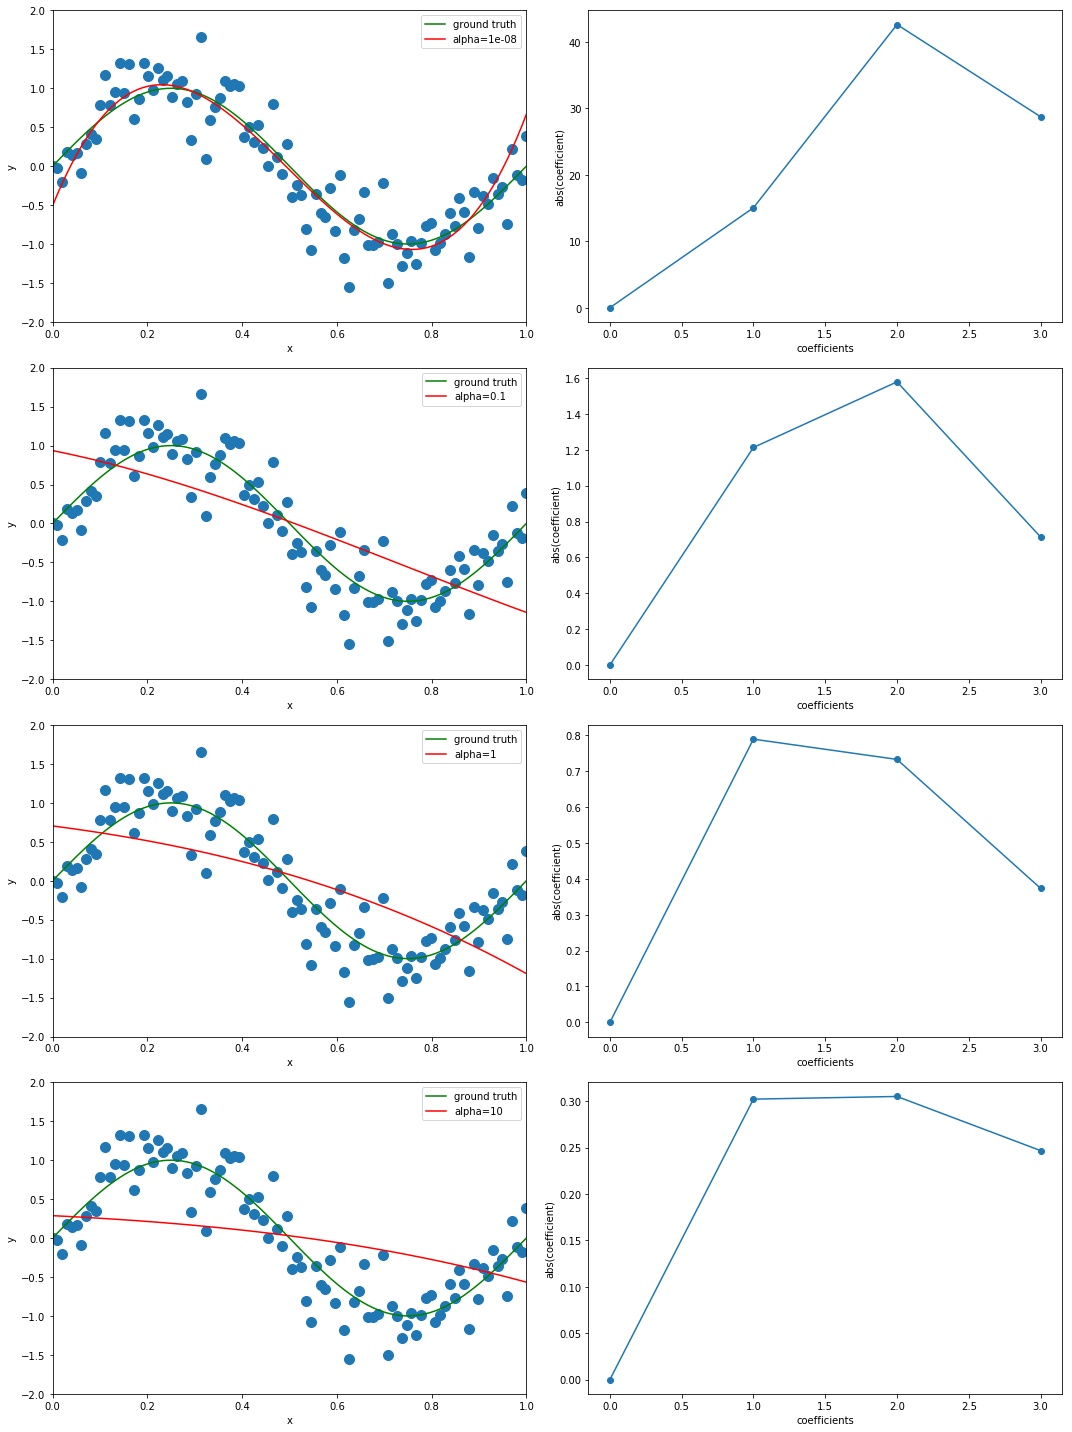

In [85]:
# We start by seeding the random number generator so that everyone will have the same "random" results
np.random.seed(9)

# Function that returns the sin(2*pi*x)
def f(x):
    return np.sin(2 * np.pi * x)

# This returns 100 evenly spaced numbers from 0 to 1
X_plot = np.linspace(0, 1, 100)

#applying model.predict(X) needs the X to be a matrix so the line below adds another dimension
X = X_plot[:, np.newaxis]

# Generate the y values by taking the sin and adding a random Gaussian (normal) noise term
y = f(X_plot) + np.random.normal(0,.3,100)

#plots the left hand column plots below

def plot_approximation(model, ax, label=None):
    """Plot the approximation of ``model`` on axis ``ax``. """
    ax.plot(X_plot, f(X_plot), label='ground truth', color='green')
    ax.scatter(X, y, s=100)
    ax.plot(X_plot, model.predict(X_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right',frameon=True)

# A helper function to plot the absolute value of the coefficients on the right-hand column plot
def plot_coefficients(model, ax, label=None):
    coef = model.steps[-1][1].coef_.ravel()
    ax.plot(np.arange(0,degree+1),np.abs(coef), marker='o', label=label)
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')

#split the data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.7)

# Set up a figure and axes for 8 plots, 2 per row for 4 rows
fig, ax_rows = plt.subplots(4, 2, figsize=(15, 20))

degree = 3
alphas = [1e-8, 1e-1, 1, 10]

for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    model.fit(X_train, y_train)
    
    print("alpha: ", alpha, "    R^2:", model.score(X_test, y_test))
    plot_approximation(model, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(model, ax_right, label='Ridge(alpha=%r) coefficients' % alpha)

plt.tight_layout()

We conclude that alpha = 1e-8 corresponding to R^2 around 80% is our best option.

That's a lot of work by hand to investigate the optimal alpha value. 

### Automatic Cross-Validation with sklearn
So far we've just been using train/test splits for cross-validation and we haven't let sklearn do the work for us.  We will now use **RidgeCV** to perform regression with automatic Regularization and Cross-Validation in just 4 lines!

Create a `RidgeCV` object with the parameter `cv` set to 10.  

What this will do is perform [10-fold cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation).  The CV in RidgeCV means that is has this capability built in.  Because this is a Ridge Regressor, it also has regularization built in.  You can check out the [RidgeCV Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) to see the default values it uses for `alpha` (they are configurable as a parameter of course).

Unfortunately, RidgeCV does not contain a shuffle argument so we will need to do that first:

In [67]:
df = pd.DataFrame(data={'X_plot':X_plot, 'y':y})
df = df.sample(frac=1).reset_index(drop=True)

y = df['y']
X_plot = df['X_plot']
X = df.drop(columns = 'y')

This tests default alpha values of alphas=(0.1, 1.0, 10.0). If we would like to specify our alpha values, we can do so. The alpha_ attribute gives us the optimal alpha value:

In [84]:
rcv = RidgeCV(cv=10, alphas = [1e-8, 1e-1, 1, 10])
model = make_pipeline(PolynomialFeatures(degree), rcv)
model.fit(X, y)
print('R2', model.score(X, y))
print('alpha: ', model.steps[1][1].alpha_)

R2 0.8461618038634724
alpha:  1e-08


Note that once again, we find the optimal alpha to be around 1e-8 with an R2 of 85%. Notice how much nicer it was, though, to simply use RidgeCV to do the work for us.


Note that the optimal value alpha found using RidgeCV may not always correspond to the optimal alpha found above using simply Ridge. This is because the manual Ridge approach is not doing any cross-validation and therefore train and test data are the same. Using RidgeCV, though, cross-validation is by default activated. The scoring process used to determine the best parameters is not using the same data for train and test.

You can print out the mean cv_values_ as you are using store_cv_values = True. This allows you to view the mean squared error of each alpha:

In [90]:
rcv = RidgeCV(alphas = [1e-8, 1e-1, 1, 10], store_cv_values = True)
model = make_pipeline(PolynomialFeatures(degree), rcv)
model.fit(X, y)
print('MSE for each alpha: ', np.mean(model.steps[1][1].cv_values_, axis=0))
print(f'MSE corresponding to best alpha {model.steps[1][1].alpha_}: {np.mean(model.steps[1][1].cv_values_, axis=0)[2]}')

MSE for each alpha:  [0.10647886 0.31318084 0.36364163 0.40929001]
MSE corresponding to best alpha 1e-08: 0.3636416283450069


### Multiple Linear Regression Cars Example
Let's return to the cars dataset. We'll read it back in using a created in which the one-hot matrix has already been created for the car makes. Let's also shuffle it since we'll be using RidgeCV:

In [100]:
df=pd.read_pickle('data/cars2frame.pkl')
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,length,width,height,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,...,make[T.nissan],make[T.peugot],make[T.plymouth],make[T.porsche],make[T.renault],make[T.saab],make[T.subaru],make[T.toyota],make[T.volkswagen],make[T.volvo]
0,169.7,63.6,59.1,3.05,3.03,9.0,62.0,4800.0,31,37,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,183.1,66.9,55.1,3.19,3.40,9.0,88.0,5500.0,25,31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,173.2,66.3,50.2,3.60,3.90,7.0,145.0,5000.0,19,24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,176.2,65.6,52.0,3.62,3.50,9.3,116.0,4800.0,24,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,176.6,66.4,54.3,3.19,3.40,8.0,115.0,5500.0,18,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In addition, recall that the price was skewed right:

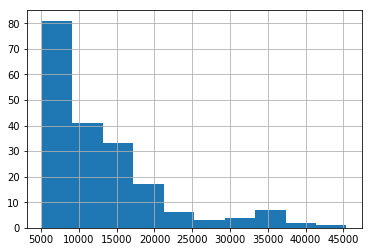

In [96]:
df['price'].hist()

Therefore, we also created a log(price) column to reduce the skew:

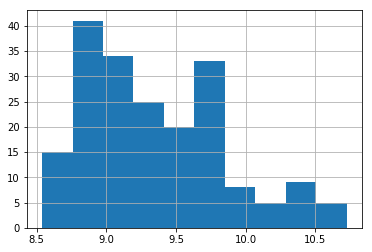

In [93]:
df['log_price'].hist()

Recall that previously, we used a simple linear regression:

In [101]:
y=df['log_price']
X=df.drop(['log_price','price'],1)

model=LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model.fit(X_train, y_train)

print(f"R^2: {model.score(X_test,y_test)}")
print(f"Adjusted R^2: {1 - (1-model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)}")

R^2: 0.8936583510266704
Adjusted R^2: 0.7196447436157674


What about Ridge CV? Typically better!

In [102]:
model = RidgeCV(cv=10)
model.fit(X, y)

print(f"R^2: {model.score(X,y)}")
print(f"Adjusted R^2: {1 - (1-model.score(X,y))*(len(y)-1)/(len(y)-X.shape[1]-1)}")

R^2: 0.9546709353380737
Adjusted R^2: 0.944342794022698


### Homework
We've been lazy for the sake of considering one new topic at a time. Recall that we should always normalize our data before applying a regression model.  Google "StandardScaler make_pipeline" to investigate how to create a pipeline that first applies the StandardScalar transformation and then applies the RidgeCV(cv=10) model to this cars dataset. 